# 核回归

在实际中，物理量z和观测量y之间的函数关系往往是非线性的，甚至无法给出具体的函数表达式。

在这种情形下，可以使用核回归方法，即利用核函数将非线性关系转化为线性关系来进行回归分析。

在核函数的作用下，任何非线性关系在局域上都可当作线性关系来处理。核回归是一种非参数统计方法。

例如高斯核函数：

$$
k(x, y) = exp(-\gamma \|x-y\|^2)
$$



设在局域上物理量z和观测量y的函数关系为常数，即：

$$
z(y) = c_0
$$

对于m个观测量 $\{ y_i\}$ 和n个想要预测的物理量 $\{ z_i\}$, 使用加权最小二乘法

即定义以核函数为权重的损失函数为：

$$
\mathcal{L} = \sum_{i=1}^n k_i(z_i - c_0)^2
$$

通过计算偏导数为0，计算最小值：

$$
\frac{\partial \mathcal{L}}{\partial c_0} = -2 \sum_{i=1}^n k_i(z_i - c_0) = 0
$$

由此可得到：

$$
z(y) = c_0 = \frac{\sum k_i z_i}{\sum k_i} = \frac{\sum k(y, y_i) z_i}{\sum k(y, y_i)} 
$$

In [40]:
import numpy as np
# ===== 2. 自定义实现 =====
class KernelRegression:
    def __init__(self, kernel="rbf", **kernel_params):
        self.kernel = kernel
        self.kernel_params = kernel_params

        if self.kernel == "rbf":
            self.kernel_func = self.__gaussian_kernel
        elif self.kernel == "linear":
            self.kernel_func = self.__linear_kernel
        elif self.kernel == "poly":
            self.kernel_func = self.__poly_kernel
        

    def predict(self, X_train, y_train, data):
        K = self.kernel_func(X_train, data, **self.kernel_params)
        weights = K / np.sum(K, axis=0) # 权重归一化
        prediction = y_train.T @ weights
        return prediction
    
    def __gaussian_kernel(self, x, y, gamma=15):
        #np.sum(x**2, axis=1)[:, None] + np.sum(y**2, axis=1) 利用广播机制，结果的shape是[100, 100]
        mse = np.sum(x**2, axis=1)[:, None] + np.sum(y**2, axis=1) - 2 * np.dot(x, y.T) #x.shape [100, 2]
        return np.exp(-gamma * mse)
    
    def __linear_kernel(self, x, y): # kpca用线性核，结果和pca一致
        return x @ y.T
    
    def __poly_kernel(self, x, y, a=1, c=2, d=4):
        return np.power(a * (x @ y.T) + c, d)

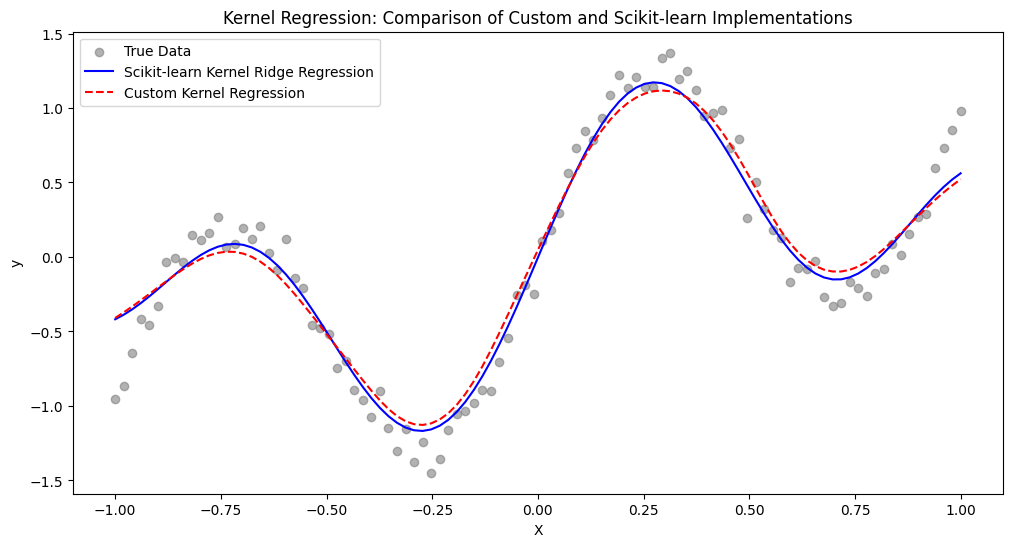

In [41]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.kernel_ridge import KernelRidge

# ===== 生成非线性数据集 =====
np.random.seed(42)
X = np.linspace(-1, 1, 100).reshape(-1, 1)
y = np.sin(2 * np.pi * X).ravel() + np.power(X, 1).ravel() + np.random.normal(0, 0.1, X.shape[0])

# 拆分数据集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 自定义实现预测
kr_custom = KernelRegression(kernel="rbf", gamma=50)
y_pred_custom = kr_custom.predict(X_train, y_train, X)

# ===== 1. 调包实现：Kernel Ridge Regression =====
# 使用 RBF 核（高斯核）实现核回归
kr_model = KernelRidge(kernel="rbf", gamma=10)
kr_model.fit(X_train, y_train)
y_pred_sklearn = kr_model.predict(X)

# ===== 绘图对比 =====
plt.figure(figsize=(12, 6))
plt.scatter(X, y, color="gray", label="True Data", alpha=0.6)
plt.plot(X, y_pred_sklearn, color="blue", label="Scikit-learn Kernel Ridge Regression")
plt.plot(X, y_pred_custom, color="red", linestyle="--", label="Custom Kernel Regression")
plt.legend()
plt.xlabel("X")
plt.ylabel("y")
plt.title("Kernel Regression: Comparison of Custom and Scikit-learn Implementations")
plt.show()
